In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap
from utils import train_colloc_parallel as train_colloc, init_params_nn, ff_nn, divergence, bd_forces, a1, a2, lr
from utils_node import NODE, init_layers, NODE_model_aniso, init_params_aniso, GOH_model
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, apply_bc_biax

from jaxinterp2d import interp2d

/var/folders/1f/rngrmz8x3lsd60h6dd90ncwm0000gr/T/ipykernel_25430/1914414784.py:5: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



## 1. Generate data + pretraining

In [3]:
# Do the FEM with jax-fem instead
def GOH_PK1(u_grad, params, dim):
    C10, k1, k2 = params
    kappa = 0.3
    theta = 0.0
    #Kinematics
    F_2D = u_grad + jnp.eye(dim)
    C_2D = F_2D.T @ F_2D
    Cinv_2D = jnp.linalg.inv(C_2D)
    detC_2D = jnp.linalg.det(C_2D)
    C33 = 1/detC_2D
    C = jnp.array([  [C_2D[0,0], C_2D[0,1], 0],\
                    [C_2D[1,0], C_2D[1,1], 0],\
                    [0,         0,       C33]])
    C2 = C @ C
    Cinv = jnp.linalg.inv(C)
    I1 = C[0,0] + C[1,1] + C[2,2]
    trC2 = C2[0,0] + C2[1,1] + C2[2,2]
    I2 = 0.5*(I1**2 - trC2)
    v0 = jnp.array([ jnp.cos(theta), jnp.sin(theta), 0])
    V0 = jnp.outer(v0, v0)
    Iv = jnp.einsum('ij,ij',C,V0)


    # Energy/Stress
    E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
    E = jnp.maximum(E, 0.0)

    Psi1 = C10 + k1*kappa*E*jnp.exp(k2*E**2)
    Psiv = k1*(1-3*kappa)*E*jnp.exp(k2*E**2)
    Psi2 = 0.0

    p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2])
    S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0
    S_2D = S[:2,:2]
    P_2D = F_2D @ S_2D
    return P_2D
GOH_vmap = vmap(GOH_PK1, in_axes=(0,0,None))
def GOH_sigma(u_grad, params, dim):
    F_2D = u_grad + jnp.eye(dim)
    P_2D = GOH_PK1(u_grad, params, dim)
    return P_2D @ F_2D.T
GOH_sigma_vmap = vmap(GOH_sigma, in_axes=(0,0,None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: GOH_PK1(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [4]:
from PIL import Image

In [6]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])
image = Image.open('data/PP.png')
image = image.rotate(-90)
image = image.resize([Nx, Ny])
image = np.array(image)
image = image.mean(axis=2)
image = image/image.max()
image = image.flatten()


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny

C10 = 1.e-3 + image*0.2*1.e-3
k1  = 0.55 + image*0.2*0.55
k2  = 8.0 + image*0.2*8.0
F_hist_goh = []
node_x_hist_goh = []
sigma_hist_goh = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)


    # GOH Material parameters
    params = np.stack([C10,k1,k2]).T.reshape([-1,1,3])
    params_vec = jnp.repeat(params, axis=1, repeats=4)
    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    sigma = GOH_sigma_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist_goh.append(F)
    node_x_hist_goh.append(node_x)
    sigma_hist_goh.append(sigma)
# node_x_hist_goh = np.array(node_x_hist_goh)
# F_hist_goh = np.array(F_hist_goh)
# sigma_hist_goh = np.array(sigma_hist_goh)

[12-15 20:44:38][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[12-15 20:44:38][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[12-15 20:44:38][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[12-15 20:44:38][DEBUG] jax_fem: Done pre-computations, took 0.043665170669555664 [s]
[12-15 20:44:38][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[12-15 20:44:38][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[12-15 20:44:38][DEBUG] jax_fem: Start timing
[12-15 20:44:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-15 20:44:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.9746 seconds
[12-15 20:44:39][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-15 20:44:39][DEBUG] jax_fem: Linear guess solve...
[12-15 20:44:39][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[12-15 20:44:39][DEBUG] jax_fem: PETS

In [7]:
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           right,                                  ],
        [1,                 0,              0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    sigma = GOH_sigma_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist_goh.append(F)
    node_x_hist_goh.append(node_x)
    sigma_hist_goh.append(sigma)

[12-15 20:45:21][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[12-15 20:45:21][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[12-15 20:45:21][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[12-15 20:45:21][DEBUG] jax_fem: Done pre-computations, took 0.04575777053833008 [s]
[12-15 20:45:21][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[12-15 20:45:21][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[12-15 20:45:21][DEBUG] jax_fem: Start timing
[12-15 20:45:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-15 20:45:22][DEBUG] jax_fem: Function split_and_compute_cell took 1.0250 seconds
[12-15 20:45:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-15 20:45:22][DEBUG] jax_fem: Linear guess solve...
[12-15 20:45:22][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[12-15 20:45:22][DEBUG] jax_fem: PETSc

In [8]:
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                     ],
        [1,                 0,              1,                                       ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    sigma = GOH_sigma_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist_goh.append(F)
    node_x_hist_goh.append(node_x)
    sigma_hist_goh.append(sigma)

[12-15 20:45:42][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[12-15 20:45:42][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[12-15 20:45:42][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[12-15 20:45:42][DEBUG] jax_fem: Done pre-computations, took 0.05811190605163574 [s]
[12-15 20:45:42][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[12-15 20:45:42][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[12-15 20:45:42][DEBUG] jax_fem: Start timing
[12-15 20:45:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-15 20:45:43][DEBUG] jax_fem: Function split_and_compute_cell took 1.0155 seconds
[12-15 20:45:43][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-15 20:45:43][DEBUG] jax_fem: Linear guess solve...
[12-15 20:45:43][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[12-15 20:45:43][DEBUG] jax_fem: PETSc

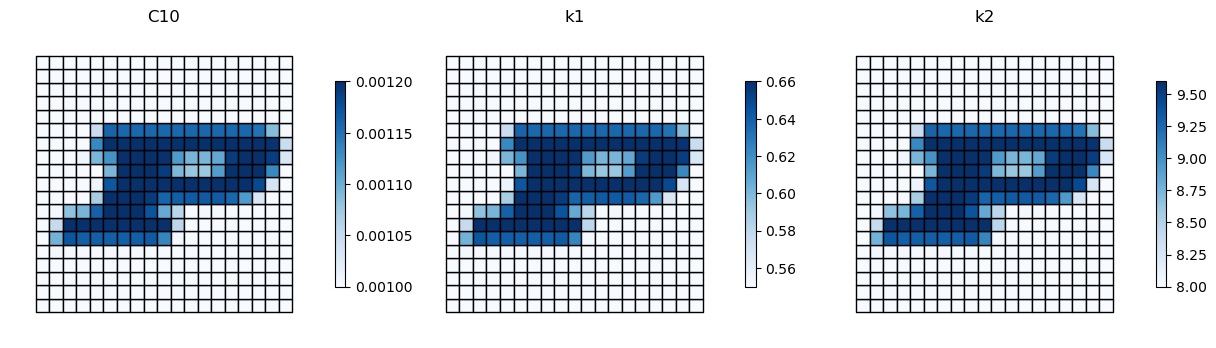

In [9]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
plotmesh(mesh.cells, mesh.points, C10, title='C10', ax=axes[0]); 
plotmesh(mesh.cells, mesh.points, k1, title='k1', ax=axes[1]); 
plotmesh(mesh.cells, mesh.points, k2, title='k2', ax=axes[2]); 

In [12]:
node_x_hist_goh = np.array(node_x_hist_goh)
F_hist_goh = np.array(F_hist_goh)
sigma_hist_goh = np.array(sigma_hist_goh)

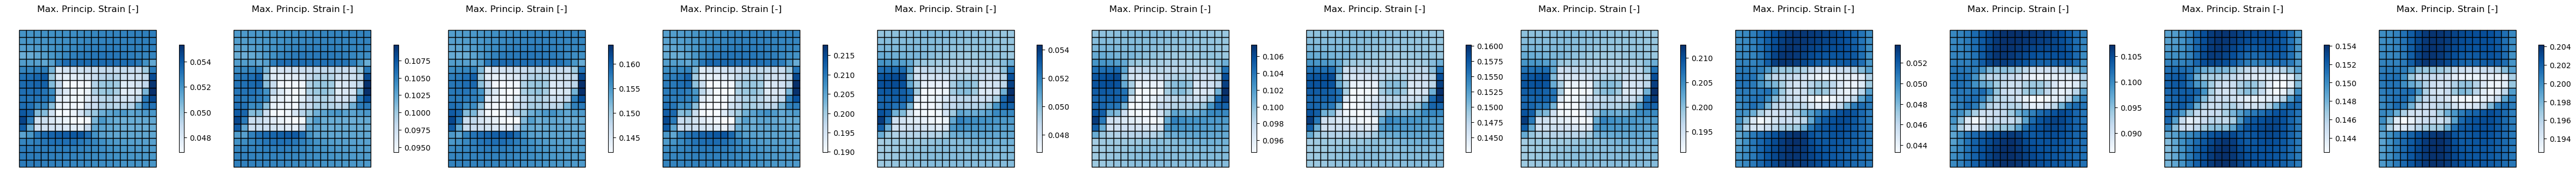

In [21]:
fig, axes = plt.subplots(1,12,figsize=(60,4))
strains = []
t_hist = np.arange(len(lmb_hist)*3)
for t, node_x, F, ax in zip(t_hist, node_x_hist_goh, F_hist_goh, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)
    strains.append(np.array([t*np.ones_like(eps_xx), eps_xx, eps_yy]))

    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 
strains = np.hstack(strains)

In [49]:
# instead of using a 2D spline, use a NN to get the strain field for a given (x,y)
def loss(params, X, key):
    inp, out_gt = X[:,:3], X[:,3:] #inp: x,y,lmb and out_gt=eps_xx, eps_yy
    t = inp[:,2:3]
    out_pr = ff_nn(inp, params)
    # out_gt = out_gt/(t+1) #dividing by t+1 just for some regularization
    # out_pr = out_pr/(t+1) #dividing by t+1 just for some regularization
    return jnp.mean((out_pr-out_gt)**2)

n_ff = 40 # 10 cosines and 10 sines in the fourier features
n_inp = 3 # x, y, lmb
ff_params = np.random.normal(size=n_inp*n_ff).reshape([n_inp,n_ff])
nn_layers = [2*n_ff,40,40,2]
nn_params = init_params_nn(nn_layers, key)
coord_2_strain_params = [ff_params, nn_params]

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(coord_2_strain_params)

X = np.vstack(np.repeat([elem_X], axis=0, repeats=len(F_hist_goh)))
inp = np.hstack([X, strains.T])
coord_2_strain_params, train_loss, _ = train(loss, inp, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=1000, batch_size=1000)

it 1000, train loss = 4.082037e-03
it 2000, train loss = 1.395097e-03
it 3000, train loss = 6.468924e-04
it 4000, train loss = 3.451537e-04
it 5000, train loss = 1.976067e-04
it 6000, train loss = 1.178904e-04
it 7000, train loss = 7.217479e-05
it 8000, train loss = 4.542969e-05
it 9000, train loss = 2.913249e-05
it 10000, train loss = 1.908083e-05
it 11000, train loss = 1.309456e-05
it 12000, train loss = 9.123170e-06
it 13000, train loss = 6.699298e-06
it 14000, train loss = 5.183496e-06
it 15000, train loss = 4.074498e-06
it 16000, train loss = 3.336437e-06
it 17000, train loss = 2.897480e-06
it 18000, train loss = 2.552159e-06
it 19000, train loss = 2.293075e-06
it 20000, train loss = 2.083079e-06
it 21000, train loss = 1.983183e-06
it 22000, train loss = 1.879155e-06
it 23000, train loss = 1.729189e-06
it 24000, train loss = 1.612016e-06
it 25000, train loss = 1.622536e-06
it 26000, train loss = 1.522978e-06
it 27000, train loss = 1.464560e-06
it 28000, train loss = 1.428326e-06
i

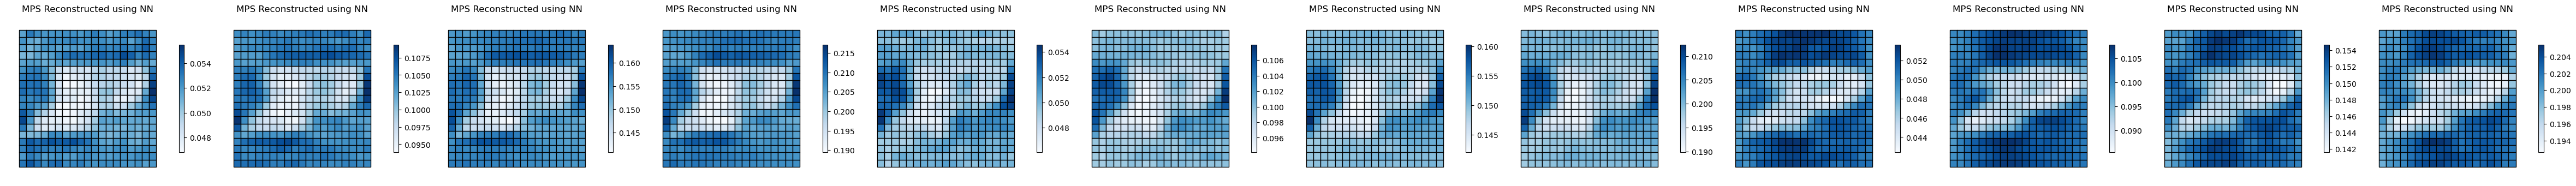

In [50]:
fig, axes = plt.subplots(1,12,figsize=(60,4))
for t in t_hist:
    ax = axes[t]
    aux = np.hstack([elem_X, t*np.ones_like(elem_X[:,:1])])
    eps_xx_pr, eps_yy_pr = ff_nn(aux, coord_2_strain_params).T
    mps_pr = np.maximum(eps_xx_pr, eps_yy_pr)

    plotmesh(mesh.cells, mesh.points, mps_pr, title='MPS Reconstructed using NN', ax=ax); 

In [51]:
# identify the boundaries
rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(mesh.cells):
    if any([mesh.points[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([mesh.points[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([mesh.points[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([mesh.points[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

# get the reaction forces by integrating the stresses of the boundary elements
rgt_bd_frc = np.sum(sigma_hist_goh[:,rgt_bd_elems,0,0], axis=1)
lft_bd_frc = np.sum(sigma_hist_goh[:,lft_bd_elems,0,0], axis=1)
top_bd_frc = np.sum(sigma_hist_goh[:,top_bd_elems,1,1], axis=1)
bot_bd_frc = np.sum(sigma_hist_goh[:,bot_bd_elems,1,1], axis=1)
Fx = jnp.array(0.5*(rgt_bd_frc + lft_bd_frc))
Fy = jnp.array(0.5*(top_bd_frc + bot_bd_frc))

# get the center points of the elements
rgt_bd_X = elem_X[rgt_bd_elems]
top_bd_X = elem_X[top_bd_elems]
lft_bd_X = elem_X[lft_bd_elems]
bot_bd_X = elem_X[bot_bd_elems]
bd_X = rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X

In [56]:
# Homogenize the strains
eps_xx_mean = np.mean(F_hist_goh[:,:,0,0]-1.0, axis=1)
eps_yy_mean = np.mean(F_hist_goh[:,:,1,1]-1.0, axis=1)
# eps_xy_mean = np.mean(0.5*(F_hist_goh[:,:,0,1]+F_hist_goh[:,:,1,0]), axis=1)
sgmx_mean = Fx/len(rgt_bd_elems)
sgmy_mean = Fy/len(top_bd_elems)
lamb_sigma_m = np.array([eps_xx_mean+1.0, eps_yy_mean+1.0, sgmx_mean, sgmy_mean]).reshape([len(lmb_hist),-1]).T

n_neurons = 4
# Define the loss function for when training all params
@jit
def loss_sig_all(params, lamb_sigma, key):
    model   = NODE_model_aniso(params)
    lambx   = lamb_sigma[:,0]
    lamby   = lamb_sigma[:,1]
    sgmx_gt  = lamb_sigma[:,2]
    sgmy_gt  = lamb_sigma[:,3]
    sgm = eval_Cauchy_aniso_vmap(lambx,lamby, model)
    sgmx_pr, sgmy_pr = sgm[:,0,0], sgm[:,1,1]
    return np.mean((sgmx_pr-sgmx_gt)**2+(sgmy_pr-sgmy_gt)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params = init_params_aniso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(node_params)

# Train
node_params, train_loss, _ = train(loss_sig_all, lamb_sigma_m, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=1000)

it 1000, train loss = 4.537721e-02
it 2000, train loss = 5.304865e-03
it 3000, train loss = 1.237047e-03
it 4000, train loss = 3.858482e-04
it 5000, train loss = 1.632795e-04
it 6000, train loss = 1.032314e-04
it 7000, train loss = 8.245302e-05
it 8000, train loss = 6.430207e-05
it 9000, train loss = 4.731493e-05
it 10000, train loss = 3.748341e-05
it 11000, train loss = 2.994953e-05
it 12000, train loss = 2.277946e-05
it 13000, train loss = 1.678157e-05
it 14000, train loss = 1.223913e-05
it 15000, train loss = 8.903716e-06
it 16000, train loss = 6.491286e-06
it 17000, train loss = 4.802847e-06
it 18000, train loss = 3.678188e-06
it 19000, train loss = 2.945837e-06
it 20000, train loss = 2.443894e-06
it 21000, train loss = 2.077729e-06
it 22000, train loss = 1.788069e-06
it 23000, train loss = 1.507146e-06
it 24000, train loss = 1.092208e-06
it 25000, train loss = 3.493691e-07
it 26000, train loss = 1.445811e-07
it 27000, train loss = 1.426202e-07
it 28000, train loss = 1.423916e-07
i

In [57]:
mymodel = NODE_model_aniso(node_params)
sgm = eval_Cauchy_aniso_vmap(eps_xx_mean+1.0,eps_yy_mean+1.0, mymodel)
sgmx, sgmy = sgm[:,0,0], sgm[:,1,1]
print('gt sgmx & sgmy: ', sgmx_mean, sgmy_mean)
print('pr sgmx & sgmy: ', sgmx, sgmy)

gt sgmx & sgmy:  [ 0.00476  0.01821  0.04508  0.0946   0.00255  0.00787  0.01703  0.03137 -0.       0.       0.       0.     ] [ 0.00239  0.0108   0.029    0.06375 -0.       0.       0.       0.       0.00031  0.00063  0.00119  0.00292]
pr sgmx & sgmy:  [ 0.00489  0.01836  0.04528  0.09449  0.00276  0.00815  0.01717  0.03111 -0.      -0.      -0.00019 -0.00053] [0.0021  0.01037 0.02881 0.06392 0.00014 0.00028 0.00042 0.00056 0.00013 0.00046 0.00112 0.00311]


In [58]:
# Fit a function Λ that maps x,y ∈ [0,1] to the individual-specific parameters of this NODE with a maximum variance of, say, 1%
phi, unravel = ravel_pytree(node_params)
n_phi = len(phi)

# ff_params = coord_2_strain_params[0]
# ff_nn2 = lambda x, nn_params: ff_nn(x, [ff_params, nn_params])
def loss_Lambda(params, inp, key):
    out_pr = ff_nn(inp, params)
    return jnp.mean((out_pr-phi)**2)

n_ff = 10
ff_params = np.random.normal(size=2*n_ff).reshape([2,n_ff])
nn_layers = [2*n_ff,40,40,n_phi]
nn_params = init_params_nn(nn_layers, key)
Lambda_params = [ff_params, nn_params]
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

inp = np.array(np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))).reshape([2,-1]).T
Lambda_params, train_loss, _ = train(loss_Lambda, inp, get_params, opt_update, opt_state, key, nIter = 5000, print_freq=1000)

it 1000, train loss = 2.475545e-04
it 2000, train loss = 9.616569e-05
it 3000, train loss = 4.403609e-05
it 4000, train loss = 2.212247e-05
it 5000, train loss = 1.173685e-05


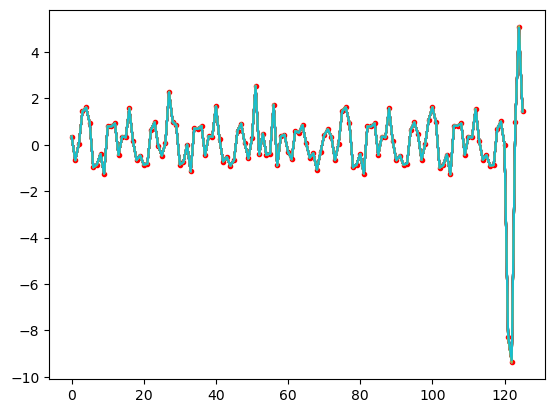

In [59]:
fig, ax = plt.subplots()
ax.plot(phi, 'r.-')
for y in np.linspace(0,1,4):
    for x in np.linspace(0,1,10):
        params = ff_nn(np.array([x,y]).reshape([1,-1]), Lambda_params)
        ax.plot(params[0])

In [60]:
with open('params/PP_pre.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Fx, Fy, strains,
                 bd_X, lmb_hist, sigma_hist_goh, F_hist_goh, node_x_hist_goh, t_hist], f)

## 2. Retrain

In [3]:
with open('params/PP_pre.npy', 'rb') as f:
    coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Fx, Fy, strains, \
                 bd_X, lmb_hist, sigma_hist_goh, F_hist_goh, node_x_hist_goh, t_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

In [62]:
# Train
@jit
def loss(Lambda_params, X):
    div_x, div_y = divergence(Lambda_params, X, bd_X, coord_2_strain_params, NODE_w_unravel)
    F_rgt, F_top, F_lft, F_bot = bd_forces(Lambda_params, X, bd_X, coord_2_strain_params, NODE_w_unravel)
    t = X[1] # a scalar
    fx = Fx[jnp.array(t, int)]
    fy = Fy[jnp.array(t, int)]
    return a1*(div_x**2 + div_y**2) + a2*((F_rgt-fx)**2 + (F_top-fy)**2 + (F_lft-fx)**2 + (F_bot-fy)**2)

lr = 1e-4
sharding = PositionalSharding(jax.devices()).reshape(n_cores, 1)
opt_init, opt_update, get_params = optimizers.adam(lr) 
opt_state = opt_init(Lambda_params)

metric1 = lambda params, X:  bd_forces(params, X, bd_X, coord_2_strain_params, NODE_w_unravel)
metric2 = lambda params, X: divergence(params, X, bd_X, coord_2_strain_params, NODE_w_unravel)

Lambda_params, val_loss, metrics = train_colloc(loss, [mesh.points, t_hist], get_params, opt_update, opt_state, 
                                            key, sharding, 'cross', nIter = 100000, print_freq=1000, metric_fns=[metric1, metric2])

with open('params/PP_post.npy', 'wb') as f:
    pickle.dump([mesh, elem_X, strains, Fx, Fy, node_params, Lambda_params, val_loss, metrics], f)

it 1000, val loss = 5.971783e-04
it 2000, val loss = 3.853400e-04
it 3000, val loss = 4.084207e-04
it 4000, val loss = 4.321446e-04
it 5000, val loss = 1.499436e-03
it 6000, val loss = 4.739633e-04
it 7000, val loss = 4.512498e-04
it 8000, val loss = 4.386344e-04
it 9000, val loss = 4.018430e-03
it 10000, val loss = 3.023292e-03
it 11000, val loss = 2.147965e-03
it 12000, val loss = 1.659957e-03
it 13000, val loss = 1.381826e-03
it 14000, val loss = 9.879420e-04
it 15000, val loss = 7.226207e-04
it 16000, val loss = 6.085510e-04
it 17000, val loss = 1.391717e-03
it 18000, val loss = 5.143249e-04
it 19000, val loss = 5.415893e-04
it 20000, val loss = 6.060328e-04
it 21000, val loss = 3.121324e-03
it 22000, val loss = 6.638732e-04
it 23000, val loss = 6.534652e-04
it 24000, val loss = 7.155604e-04
it 25000, val loss = 7.128203e-04
it 26000, val loss = 5.628888e-04
it 27000, val loss = 5.908292e-04
it 28000, val loss = 4.968436e-04
it 29000, val loss = 4.766851e-04
it 30000, val loss = 8.

## 3. Test

In [63]:
with open('params/PP_post.npy', 'rb') as f:
    mesh, elem_X, strains, Fx, Fy, node_params, Lambda_params, val_loss, metrics = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

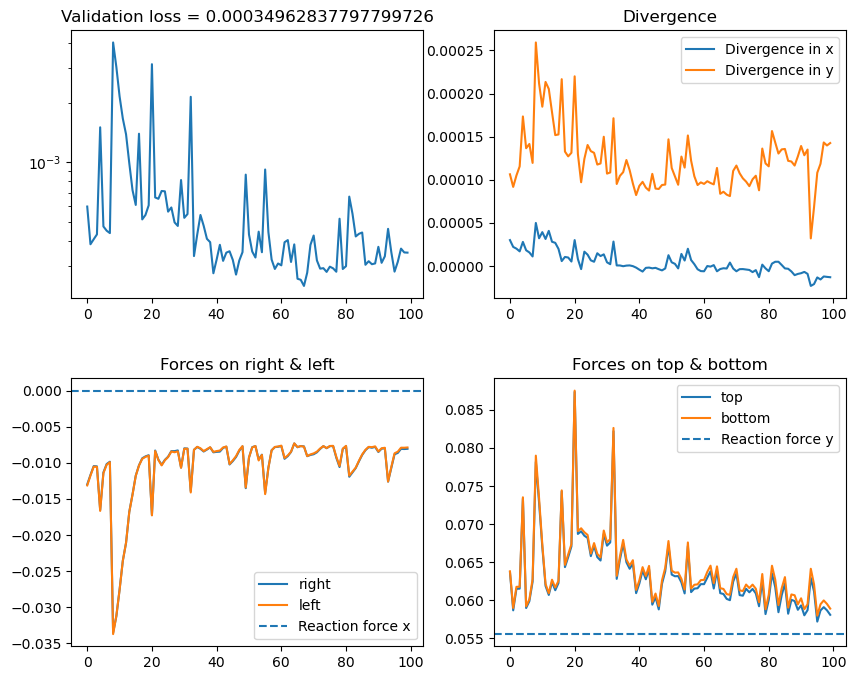

In [64]:
forces = []
div = []
for i in range(len(metrics)):
    forces.append(metrics[i][0])
    div.append(metrics[i][1])
forces = np.array(forces)
div = np.array(div)

fig, ax = plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
ax[0,0].plot(val_loss)
ax[0,1].plot(div[:,0], label='Divergence in x')
ax[0,1].plot(div[:,1], label='Divergence in y')

ax[1,0].plot(forces[:,0], label='right')
ax[1,1].plot(forces[:,1], label='top')
ax[1,0].plot(forces[:,2], label='left')
ax[1,1].plot(forces[:,3], label='bottom')

ax[1,0].axhline(Fx[-1], linestyle='--', label='Reaction force x')
ax[1,1].axhline(Fy[-1], linestyle='--', label='Reaction force y')

# ax[0,0].set(yscale='log')
ax[0,0].set(title='Validation loss = ' + str(val_loss[-1]), yscale = 'log')
ax[0,1].set(title='Divergence')
ax[1,0].set(title='Forces on right & left')
ax[1,1].set(title='Forces on top & bottom')
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

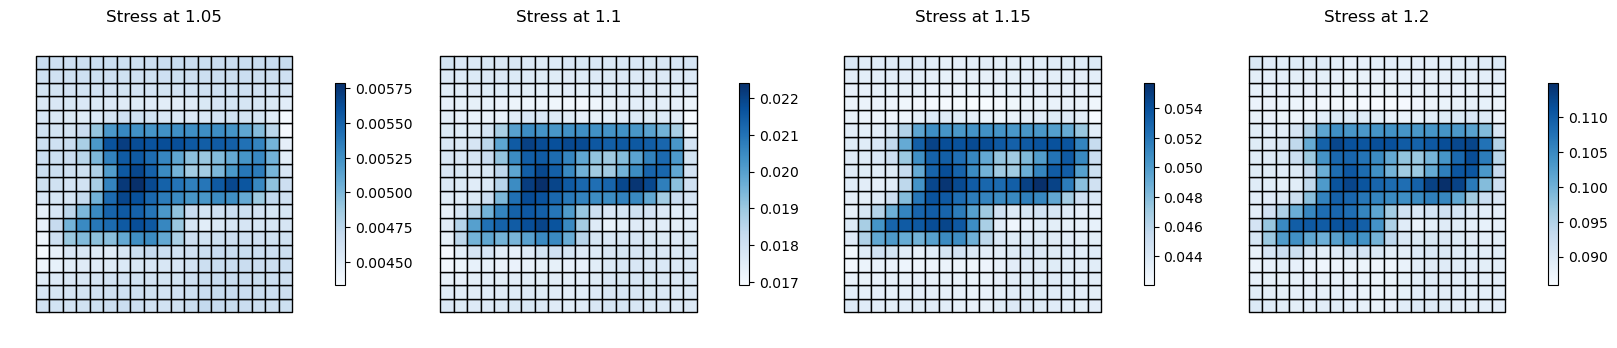

In [65]:
# Stiffness across the domain
fig, axes = plt.subplots(1,4,figsize=(20,4))
for lmb, ax in zip(lmb_hist, axes):
    c_elem = []
    for x, y in elem_X:
        Lambda_inp = jnp.array([x,y]).reshape([-1,2])
        phi = ff_nn(Lambda_inp, Lambda_params).flatten()
        mymodel = NODE_w_unravel(phi)
        c_elem.append(eval_Cauchy_aniso(lmb, lmb, mymodel)[0,0])
    c_elem = np.array(c_elem)
    plotmesh(mesh.cells, mesh.points, c_elem, title='Stress at {}'.format(str(lmb)), ax=ax); 

In [66]:
# Do the FEM with jax-fem instead
def NODE_PK1(u_grad, params, dim):
    theta = 0.0
    #Kinematics
    F_2D = u_grad + jnp.eye(dim)
    C_2D = F_2D.T @ F_2D
    Cinv_2D = jnp.linalg.inv(C_2D)
    detC_2D = jnp.linalg.det(C_2D)
    C33 = 1/detC_2D
    C = jnp.array([  [C_2D[0,0], C_2D[0,1], 0],\
                    [C_2D[1,0], C_2D[1,1], 0],\
                    [0,         0,       C33]])
    C2 = C @ C
    Cinv = jnp.linalg.inv(C)
    I1 = C[0,0] + C[1,1] + C[2,2]
    trC2 = C2[0,0] + C2[1,1] + C2[2,2]
    I2 = 0.5*(I1**2 - trC2)
    v0 = jnp.array([ jnp.cos(theta), jnp.sin(theta), 0])
    w0 = jnp.array([-jnp.sin(theta), jnp.cos(theta), 0])
    V0 = jnp.outer(v0, v0)
    W0 = jnp.outer(w0, w0)
    Iv = jnp.einsum('ij,ij',C,V0)
    Iw = jnp.einsum('ij,ij',C,W0)

    # Energy/Stress
    model = NODE_w_unravel(params)
    Psi1 = model.Psi1(I1,I2,Iv,Iw)
    Psi2 = model.Psi2(I1,I2,Iv,Iw)
    Psiv = model.Psiv(I1,I2,Iv,Iw)
    Psiw = model.Psiw(I1,I2,Iv,Iw)
    
    p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2] + 2*Psiw*W0[2,2])
    S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0 + 2*Psiw*W0
    S_2D = S[:2,:2]
    P_2D = F_2D @ S_2D
    return P_2D
NODE_vmap = vmap(NODE_PK1, in_axes=(0,0,None))
def NODE_sigma(u_grad, params, dim):
    F_2D = u_grad + jnp.eye(dim)
    P_2D = NODE_PK1(u_grad, params, dim)
    return P_2D @ F_2D.T
NODE_sigma_vmap = vmap(NODE_sigma, in_axes=(0,0,None))
class NODE_HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: NODE_PK1(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [67]:
params_vec = []
for x, y in elem_X:
    Lambda_inp = np.array([x,y]).reshape([-1,2])
    phi = ff_nn(Lambda_inp, Lambda_params).flatten()
    params_vec.append(phi)
params_vec = jnp.array(params_vec).reshape([len(params_vec),1,-1])
params_vec = jnp.repeat(params_vec, axis=1, repeats=4)

In [68]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist = []
node_x_hist = []
sigma_hist = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = NODE_HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    sigma = NODE_sigma_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist.append(F)
    node_x_hist.append(node_x)
    sigma_hist.append(sigma)
node_x_hist = np.array(node_x_hist)
F_hist = np.array(F_hist)
sigma_hist = np.array(sigma_hist)

[12-16 15:44:06][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[12-16 15:44:06][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[12-16 15:44:06][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[12-16 15:44:06][DEBUG] jax_fem: Done pre-computations, took 0.04695296287536621 [s]
[12-16 15:44:06][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[12-16 15:44:06][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[12-16 15:44:06][DEBUG] jax_fem: Start timing
[12-16 15:44:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-16 15:44:09][DEBUG] jax_fem: Function split_and_compute_cell took 2.6079 seconds
[12-16 15:44:09][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-16 15:44:09][DEBUG] jax_fem: Linear guess solve...
[12-16 15:44:09][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[12-16 15:44:09][DEBUG] jax_fem: PETSc

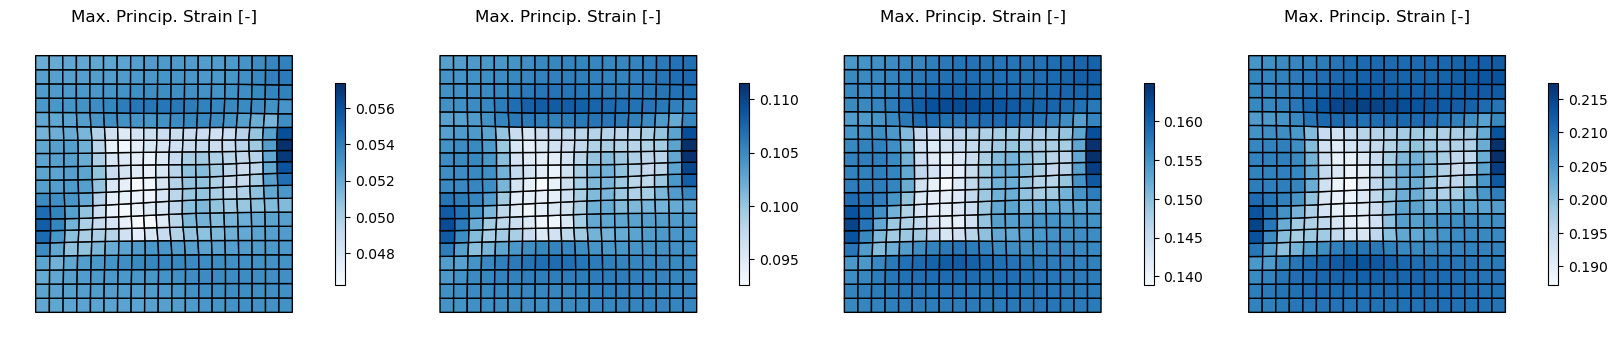

In [69]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist, F_hist, sigma_hist, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)
    strains.append(np.array([t*np.ones_like(eps_xx), eps_xx, eps_yy]))

    plotmesh(mesh.cells, node_x, mps, title='Max. Princip. Strain [-]', ax=ax); 
strains = np.hstack(strains)